# Guide RNA assignment

Assigning relevant guides to each cell is essential for quality control in perturbation assays, ensuring that the observed cellular responses are accurately linked to the intended genetic modifications. 
This step is critical for validating the experimental design and interpreting results reliably, thereby maintaining the integrity and reproducibility of the research.
Here, we demonstrate how to visualize guide RNAs in a perturbation assay and how to assign relevant guides to each cell.

## Setup

In [1]:
import jax.numpy as jnp
import numpy as np
import pandas as pd
import pertpy as pt
import scanpy as sc
import scipy
from jax import random

## Simulated Data

This function generates a toy single-cell dataset with simulated CRISPR guide assignments.
It creates `n_guides` different guides, each with a mixture of positive and negative cell populations:
- Negative populations are sampled from a Poisson distribution with a low mean (λ=0.1).
- Positive populations are sampled from a Gaussian distribution (μ=3, σ=1), clipped at zero to ensure non-negative values, except guide 2 which gets special "double positive" handling that overwrites the Poisson data.

In [2]:
def generate_toy_data(n_guides: int = 2, n_cells_per_group: int = 50):
    dats = []
    for i in range(n_guides):
        key = random.PRNGKey(i)
        key1, key2, key3 = random.split(key, num=3)

        # Negative first
        poisson_data = random.poisson(key1, lam=0.1, shape=(n_cells_per_group * i,)).astype(jnp.float32)
        if i == 1:  # Add a double positive population for the second guide
            poisson_data = random.normal(key3, shape=(n_cells_per_group,)) * 1.0 + 3
            poisson_data = poisson_data.clip(0.0, None)

        # Positive
        gaussian_data = random.normal(key2, shape=(n_cells_per_group,)) * 1.0 + 3
        gaussian_data = gaussian_data.clip(0.0, None)

        # Negative second
        poisson_data_ = random.poisson(key1, lam=0.1, shape=(n_cells_per_group * (n_guides - i - 1),)).astype(
            jnp.float32
        )

        # The count vector for one guide is the concatenation of the negative and positive populations
        guide_data = jnp.hstack([poisson_data, gaussian_data, poisson_data_])
        dats.append(guide_data)
    guide_counts = np.array(jnp.vstack(dats)).T

    # Combine Poisson and Gaussian data into one dataset
    adata = sc.AnnData(
        guide_counts,
        obs=pd.DataFrame(index=[f"cell{i + 1}" for i in range(guide_counts.shape[0])]),
        var=pd.DataFrame(index=[f"guide{i + 1}" for i in range(guide_counts.shape[1])]),
    )
    adata.obs["ground_truth"] = ["guide" + str(i + 1) for i in range(n_guides) for _ in range(n_cells_per_group)]
    col = adata.obs["ground_truth"].copy()
    col.iloc[:n_cells_per_group] = "guide1+guide2"
    adata.obs["ground_truth"] = col
    return adata

Generate a small simulated dataset with 3 guides and 50 cells per guide.
The first cell population is positive for both guide 1 and guide 2 simultaneously.

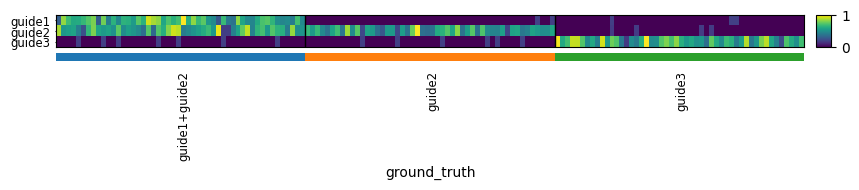

In [3]:
adata = generate_toy_data(n_guides=3, n_cells_per_group=50)
sc.pl.heatmap(
    adata, groupby="ground_truth", cmap="viridis", standard_scale="var", var_names=adata.var_names, swap_axes=True
)

Let's visualize the data more directly:

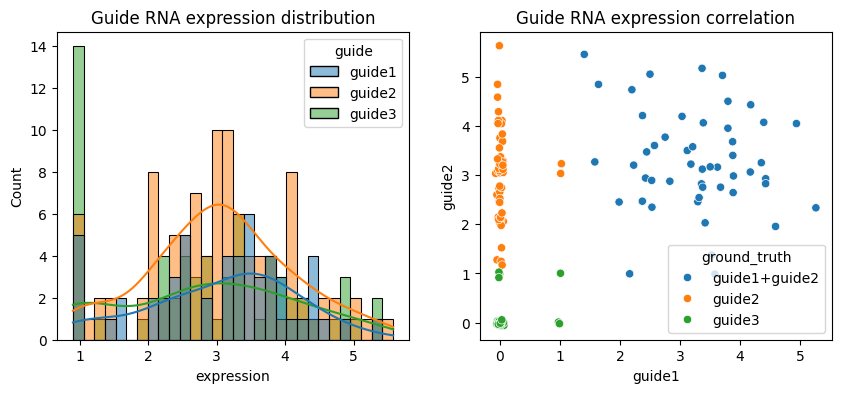

In [4]:
df = adata.to_df().stack().reset_index().rename(columns={"level_0": "cell", "level_1": "guide", 0: "expression"})
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
df = df[df.expression > 0]
sns.histplot(df, x="expression", hue="guide", bins=30, kde=True, ax=axs[0])
axs[0].set_title("Guide RNA expression distribution")
df = adata.to_df()
df = np.random.default_rng().normal(0, 0.03, df.shape) + df  # Add jitter
sns.scatterplot(data=df, x="guide1", y="guide2", hue=adata.obs["ground_truth"], ax=axs[1])
axs[1].set_title("Guide RNA expression correlation")
plt.show()

### Mixture model

We can use the `assign_mixture_model` functionality for guide assignment.
For each guide, this function fits a Poisson-Gaussian mixture model to the data and assigns each cell to the guide with the highest probability.
The model assumes that the negative populations are Poisson-distributed and the positive populations are Gaussian-distributed. Notably, this model is able to assign cells as negative for any guide or multiple guides, which is useful for quality control and in case of low and high MOIs.

In [5]:
ga = pt.pp.GuideAssignment()
ga.assign_mixture_model(adata, assigned_guides_key="assigned_guide_mixture_model")

We can compare the actual vs the inferred guide expression for each cell:

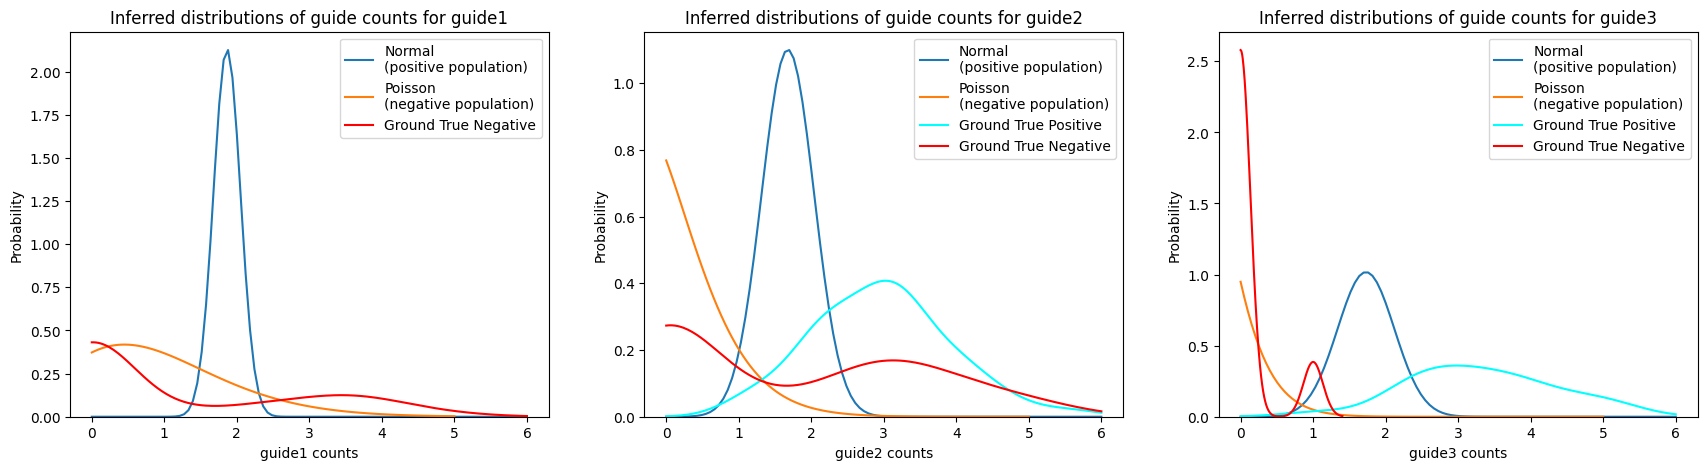

In [6]:
import numpyro.distributions as dist

# plot probability distributions of model
n_guides = len(adata.var_names)
guides = adata.var_names
fig, axs = plt.subplots(1, n_guides, figsize=(7 * n_guides, 5))
for ax, guide in zip(axs, guides):
    # plot gaussian distribution
    x = np.linspace(0, 6, 100)
    y = dist.Normal(
        adata.var.loc[guide, "gaussian_mean"],
        adata.var.loc[guide, "gaussian_std"],
    ).log_prob(x)
    ax.plot(x, np.exp(y), label="Normal\n(positive population)")
    # plot poisson distribution
    x = np.linspace(0, 5, 100)
    y = dist.Poisson(adata.var.loc[guide, "poisson_rate"]).log_prob(x)
    ax.plot(x, np.exp(y), label="Poisson\n(negative population)")

    # Plot ground truth empirical distribution
    sns.kdeplot(
        np.ravel(adata[adata.obs.ground_truth == guide, guide].X),
        color="cyan",
        label="Ground True Positive",
        ax=ax,
        clip=(0, 6),
    )
    sns.kdeplot(
        np.ravel(adata[adata.obs.ground_truth != guide, guide].X),
        color="red",
        label="Ground True Negative",
        ax=ax,
        clip=(0, 6),
    )

    ax.set_xlabel(f"{guide} counts")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.set_title(f"Inferred distributions of guide counts for {guide}")

plt.show()

Since we know which cell is **supposed** to be positive for which guide, we can evaluate the performance of the guide assignment method.
We can calculate the accuracy, precision, recall, and F1 score for each guide, and visualize the confusion matrix:

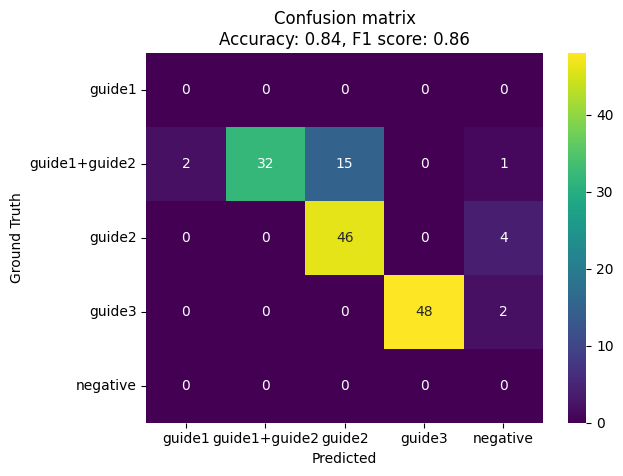

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(adata.obs["ground_truth"], adata.obs["assigned_guide_mixture_model"])
f1 = f1_score(adata.obs["ground_truth"], adata.obs["assigned_guide_mixture_model"], average="weighted")

all_labels = np.union1d(adata.obs["ground_truth"].unique(), np.unique(adata.obs["assigned_guide_mixture_model"]))

cm = confusion_matrix(adata.obs["ground_truth"], adata.obs["assigned_guide_mixture_model"], labels=all_labels)
cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)

ax = sns.heatmap(cm_df, annot=True, fmt="d", cmap="viridis")
ax.set_ylabel("Ground Truth")
ax.set_xlabel("Predicted")
plt.title(f"Confusion matrix\nAccuracy: {np.round(accuracy, 2)}, F1 score: {np.round(f1, 2)}")
plt.show()

### Threshold model

We can also assign guides using a threshold or maximum and compare the results:

In [8]:
ga.assign_by_threshold(adata, assignment_threshold=1, output_layer="assigned_guide_threshold")
ga.assign_to_max_guide(adata, assignment_threshold=1, obs_key="assigned_guide_max")

# Convert the threshold assignment to a string
matrix = adata.layers["assigned_guide_threshold"]
result = []
for row in np.asarray(matrix):  # Convert to a standard 2D array
    indices = [f"guide{i + 1}" for i, val in enumerate(row) if val == 1]
    result.append("+".join(indices) if indices else None)
adata.obs["assigned_guide_threshold"] = result
adata.obs.loc[adata.obs["assigned_guide_threshold"].isna(), "assigned_guide_threshold"] = "Negative"

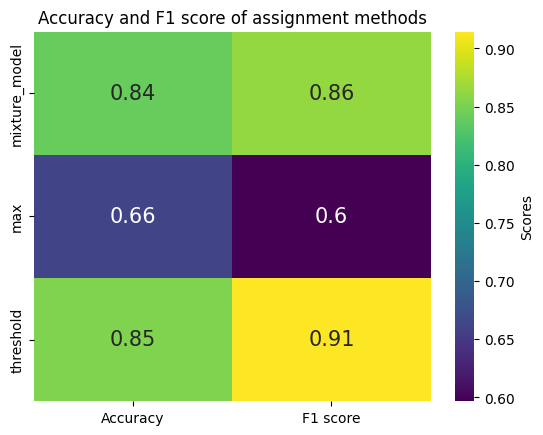

In [9]:
evaluation = {}
for key in ["assigned_guide_mixture_model", "assigned_guide_max", "assigned_guide_threshold"]:
    evaluation[key] = (
        accuracy_score(adata.obs["ground_truth"], adata.obs[key]),
        f1_score(adata.obs["ground_truth"], adata.obs[key], average="weighted"),
    )
df = pd.DataFrame(evaluation, index=["Accuracy", "F1 score"]).T
df.index = df.index.str.replace("assigned_guide_", "")
sns.heatmap(df, annot=True, cmap="viridis", annot_kws={"size": 15}, cbar_kws={"label": "Scores"})
plt.title("Accuracy and F1 score of assignment methods")
plt.show()

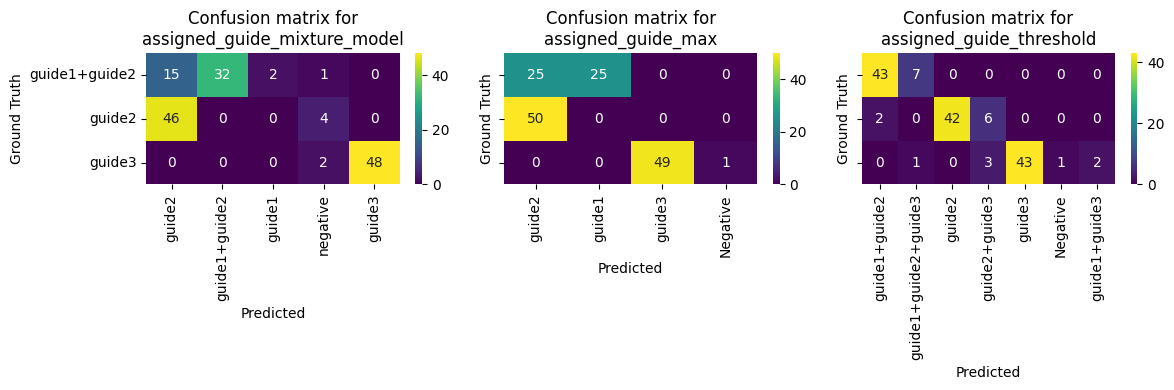

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(4 * 3, 4), sharey=True)
for ax, key in zip(axs, ["assigned_guide_mixture_model", "assigned_guide_max", "assigned_guide_threshold"]):
    gt_labels = adata.obs["ground_truth"].unique()
    pred_labels = adata.obs[key].unique()
    all_labels = np.union1d(gt_labels, pred_labels)

    cm = confusion_matrix(adata.obs["ground_truth"], adata.obs[key], labels=all_labels)
    cm = pd.DataFrame(cm, index=all_labels, columns=all_labels)
    cm = cm.loc[gt_labels, pred_labels]

    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax)
    ax.set_ylabel("Ground Truth")
    ax.set_xlabel("Predicted")
    ax.set_title(f"Confusion matrix for\n{key}")
    plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

We can see that the mixture model approach is more robust to noise and can handle more complex data distributions.
The max approach is less robust and may not work well in real data with mixed populations.

## Real Data

All guides should be available as a separate AnnData object containing counts of each guide for each cell.
The `var_names` of the AnnData correspond to the ID of these guides. In this example the 'gdo' modality contains guide RNA expression values.

Let's load the Papalexi dataset. We will try to reproduce the guide assignment of the dataset.

In [11]:
mdata = pt.dt.papalexi_2021()
# seems like an error in the original data
mdata.mod["gdo"].X = scipy.sparse.csr_matrix(mdata.mod["gdo"].X.toarray() - 1)
mdata.push_obs(columns=["gdo:guide_ID"], mods="gdo")
gdo = mdata.mod["gdo"]
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'nCount_GDO', 'guide_ID'
    var: 'name'

Then we save the original count values and transform the data using log transformation.

In [12]:
gdo.layers["counts"] = gdo.X.copy()
sc.pp.log1p(gdo)
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'nCount_GDO', 'guide_ID'
    var: 'name'
    uns: 'log1p'
    layers: 'counts'

We can visualize the expression of guides per cells to get more insight. By passing the argument `key_to_save_order` to the function, the order of cells in the plot will be saved in obs of the data.

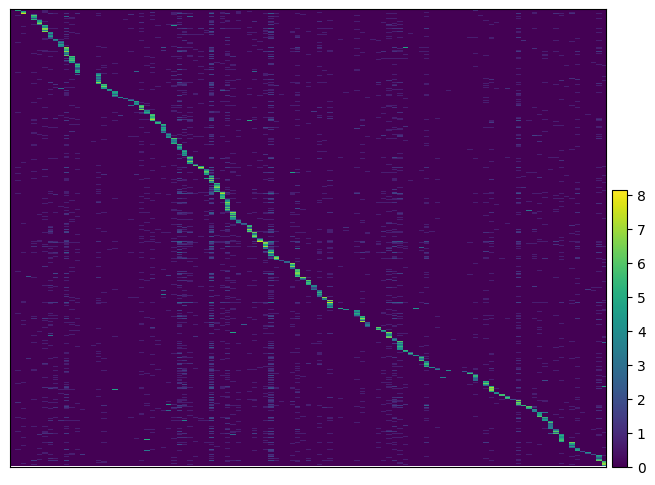

In [13]:
ga = pt.pp.GuideAssignment()
ga.plot_heatmap(gdo, key_to_save_order="plot_order")

### Most frequent guide

We can also assign to the guide RNA with the highest detection:

In [14]:
print("Available obs columns:", gdo.obs.columns.tolist())

Available obs columns: ['nCount_GDO', 'guide_ID', 'plot_order']


In [15]:
ga = pt.pp.GuideAssignment()
ga.assign_to_max_guide(gdo, assignment_threshold=5, layer="counts")

As we see it completely maches the guide assignment in the mixscape pipeline:

In [16]:
sum(gdo.obs["assigned_guide"] != gdo.obs["guide_ID"])

0

/home/lukas/miniforge3/envs/pertpy/lib/python3.13/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


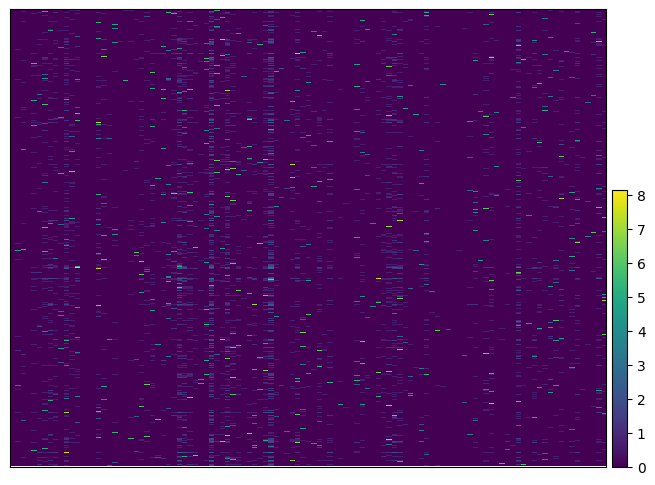

In [17]:
ga.plot_heatmap(gdo, order_by="plot_order")

### Mixture model

<div class="alert alert-block alert-info">
⚠️ The Mixture Model guide assignment method will be very slow if JAX is not installed with CUDA support.
</div>

We will heavily subset the original dataset so this can run on CPU as well in a reasonable time.

In [18]:
gdo_schmol = gdo[:5000, :10].copy()
gdo_schmol.X = gdo_schmol.layers["counts"].copy()

In [19]:
ga = pt.pp.GuideAssignment()
ga.assign_mixture_model(gdo_schmol, assigned_guides_key="assigned_guide_mixture_model", show_progress=True)

Output()

/tmp/ipykernel_256633/359173462.py:2: UserWarning: Skipping eGFPg1 as there are less than 2 cells expressing the 
guide at all.
  ga.assign_mixture_model(gdo_schmol, assigned_guides_key="assigned_guide_mixture_model", show_progress=True)

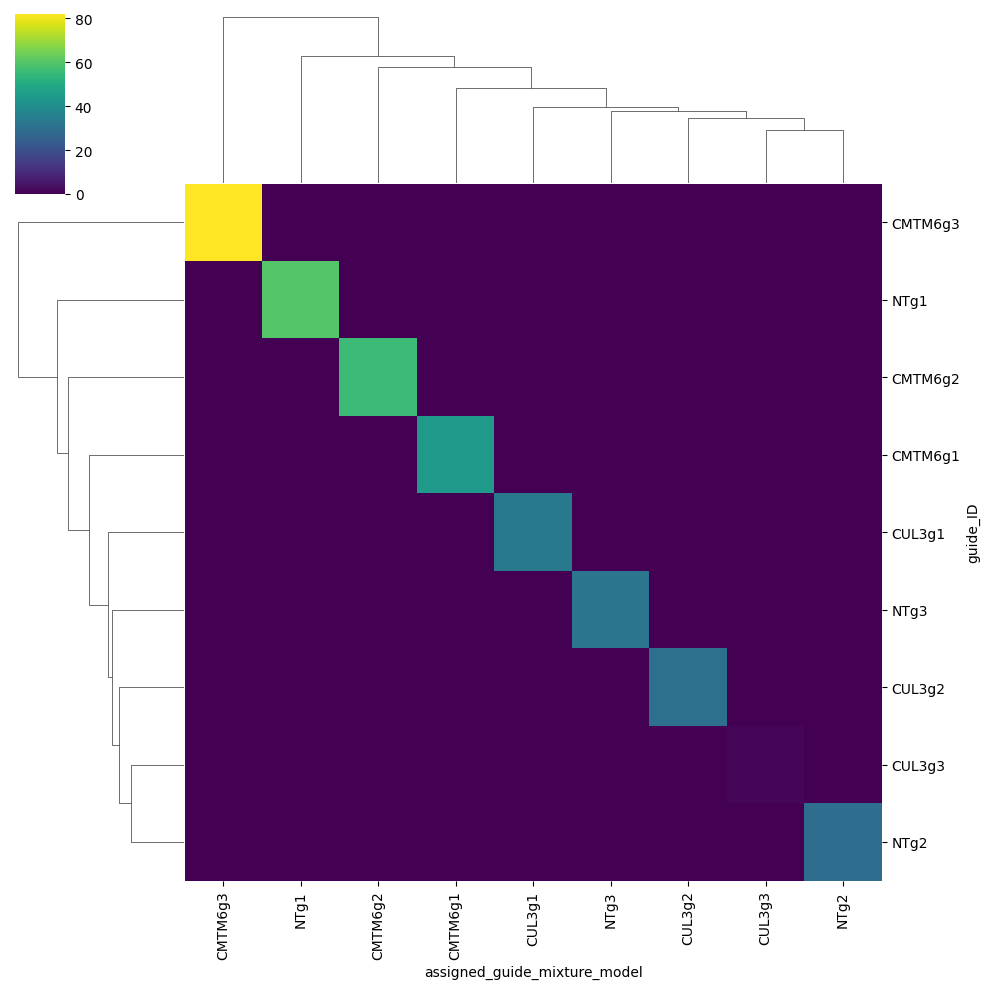

In [20]:
import seaborn as sns

pdf = (
    gdo_schmol.obs[["guide_ID", "assigned_guide_mixture_model"]]
    .value_counts()
    .reset_index()
    .rename(columns={0: "count"})
    .pivot(index="guide_ID", columns="assigned_guide_mixture_model", values="count")
    .fillna(0)
)
fitted_guides = np.intersect1d(gdo_schmol.var_names, pdf.index)
spdf = pdf.loc[fitted_guides, fitted_guides]
sns.clustermap(spdf, cmap="viridis")